#Local RAG LLM Example <Br>
This is a learning example, and has been modified from: https://github.com/mrdbourke/simple-local-rag

In [86]:
import os

pdf_path = "human-nutrition-text.pdf"

In [26]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number -41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

Now let's get a random sample of the pages.

In [27]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 676,
  'page_char_count': 775,
  'page_word_count': 119,
  'page_sentence_count_raw': 12,
  'page_token_count': 193.75,
  'text': 'differences among different studies.1 Additionally, this review states  that there is no convincing evidence from six clinical trials that  selenium supplements reduce cancer risk.  Because of its role as a lipid protector, selenium has been  suspected to prevent cardiovascular disease. In some observational  studies, low levels of selenium are associated with a decreased risk  of cardiovascular disease. However, other studies have not always  confirmed this association and clinical trials are lacking.  Figure 11.4 Selenium’s Role in Detoxifying Free Radicals  1. Dennert G, Zwahlen M, et al. (2011). Selenium for  Preventing Cancer. Cochrane Database of Systematic  Reviews,5. http://www.ncbi.nlm.nih.gov/pubmed/ 21563143. Accessed November 22, 2017.  676  |  Selenium'},
 {'page_number': 558,
  'page_char_count': 1803,
  'page_word_count': 292

### Get some stats on the text

In [30]:
# Get stats
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


Okay, looks like our average token count per page is 287.

For this particular use case, it means we could embed an average whole page with the [`all-MiniLM-L6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)

The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

> **Resource:** See [spaCy install instructions](https://spacy.io/usage). 

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`. 

In [31]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

We don't necessarily need to use spaCy, however, it's an open-source library designed to do NLP tasks like this at scale.

So let's run our small sentencizing pipeline on our pages of text.

In [32]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [33]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 381,
  'page_char_count': 1179,
  'page_word_count': 215,
  'page_sentence_count_raw': 8,
  'page_token_count': 294.75,
  'text': 'Image by  Allison  Calabrese /  CC BY 4.0  protein it can be acquired from the additional amino acids that exist  within the body. Amino acids are used not only to build proteins,  but also to build other biological molecules containing nitrogen,  such as DNA, RNA, and to some extent to produce energy. It is  critical to maintain amino acid levels within this cellular pool by  consuming high-quality proteins in the diet, or the amino acids  needed for building new proteins will be obtained by increasing  protein destruction from other tissues within the body, especially  muscle. This amino acid pool is less than one percent of total body- protein content. Thus, the body does not store protein as it does  with carbohydrates (as glycogen in the muscles and liver) and lipids  (as triglycerides in adipose tissue).  Figure 6.8 Options For Amino 

Wonderful!

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [34]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Now we've got our text split into sentences, how about we gorup those sentences?

### Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.

As you might've guessed, this process is referred to as **chunking**.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

Something to note is that there are many different ways emerging for creating chunks of information/text.

For now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).

On average each of our pages has 10 sentences.

And an average total of 287 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.

This gives us plenty of room for the text to embedded by our `all-MiniLM-L6-v2` model (it has a capacity of 384 tokens).

To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [35]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 22,
  'page_char_count': 1542,
  'page_word_count': 242,
  'page_sentence_count_raw': 14,
  'page_token_count': 385.5,
  'text': "Physical Activity  In 2008, the Health and Human Services (HHS) released the Physical  Activity Guidelines for Americans1. The HHS states that “Being  physically active is one of the most important steps that Americans  of all ages can take to improve their health. The 2008 Physical  Activity Guidelines for Americans provides science-based guidance  to help Americans aged six and older improve their health through  appropriate physical activity.” The guidelines recommend exercise  programs for people in many different stages of their lifecycle. The  HHS reports that there is strong evidence that increased physical  activity decreases the risk of early death, heart disease, stroke,  Type 2 diabetes, high blood pressure, and certain cancers; prevents  weight gain and falls; and improves cognitive function in the elderly.  These guidelines are 

In [36]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [37]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [38]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 857,
  'sentence_chunk': 'Ellyn Satter’s division of responsibility in feeding.https://www.ellynsatterinstitute.org/wp- content/uploads/2016/11/handout-dor-tasks- cap-2016.pdf Toddler Years | 857',
  'chunk_char_count': 169,
  'chunk_word_count': 13,
  'chunk_token_count': 42.25}]

Excellent!

Now we've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.

This means we could reference a chunk of text and know its source.

Let's get some stats about our chunks.

In [39]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [40]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 10.5 | Text: The Major Types of Foodborne Illness | 993
Chunk token count: 23.75 | Text: Unfortunately, a mother’s intention alone may not be enough to make this practice Infancy | 821
Chunk token count: 25.25 | Text: The Polynesian Family System in Ka-‘u. Rutland, Vermont: Charles E. Tuttle Company 780 | Introduction
Chunk token count: 17.75 | Text: Table 6.1 Essential and Nonessential Amino Acids Defining Protein | 365
Chunk token count: 19.25 | Text: 2018). Centers for Disease Control and 998 | The Causes of Food Contamination


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [41]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

Smaller chunks filtered!

Time to embed our chunks of text!

### Embedding our text chunks

While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

But one of my favourite and simple definitions is "a useful numerical representation".

The most powerful thing about modern embeddings is that they are *learned* representations.

Meaning rather than directly mapping words/tokens/characters to numbers directly (e.g. `{"a": 0, "b": 1, "c": 3...}`), the numerical representation of tokens is learned by going through large corpuses of text and figuring out how different tokens relate to each other.

Ideally, embeddings of text will mean that similar meaning texts have similar numerical representation.

> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combinations of words and characters rather than always whole words or single characters. For example, the string `"hello world!"` gets mapped to the token values `{15339: b'hello', 1917: b' world', 0: b'!'}` using [Byte pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (or BPE via OpenAI's [`tiktoken`](https://github.com/openai/tiktoken) library). Google has a tokenization library called [SentencePiece](https://github.com/google/sentencepiece).

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).

Once our text samples are in embedding vectors, us humans will no longer be able to understand them.

However, we don't need to.

The embedding vectors are for our computers to understand.

We'll use our computers to find patterns in the embeddings and then we can use their text mappings to further our understanding.

Enough talking, how about we import a text embedding model and see what an embedding looks like.

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-MiniLM-L6-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

In [43]:
# Embedding Model Path
embedding_model_path = "path/to/embedding_model"
llm_path = "path/to/llm"

In [50]:
%%time
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path=embedding_model_path, 
                                      device="cpu")

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 12.9 s
Wall time: 13 s


In [46]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [47]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: total: 3.95 s
Wall time: 2.23 s


tensor([[-1.9507e-02, -1.8256e-02,  7.1663e-04,  ..., -3.9904e-02,
         -2.1543e-02, -4.3294e-02],
        [ 2.6605e-02,  1.8786e-03, -7.0033e-03,  ..., -2.1591e-02,
         -2.1828e-02, -6.9988e-02],
        [ 3.4971e-02,  4.0597e-02, -1.9747e-02,  ..., -3.5225e-02,
         -3.1397e-02, -4.6613e-02],
        ...,
        [-3.2258e-02, -2.4768e-02, -1.1571e-02,  ..., -1.3930e-05,
          3.9905e-02, -5.2110e-02],
        [-8.8627e-02, -6.6496e-02, -1.0430e-01,  ..., -3.0128e-02,
          8.4004e-02, -4.2208e-02],
        [-1.1203e-01, -4.9535e-02, -2.4896e-02,  ...,  1.2983e-02,
          4.6920e-02, -2.8276e-02]], device='cuda:0')

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [48]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [49]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[-1.95069313e-02 -1.82564277e-02 7.16570008e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 2.66053192e-02 1.87854550e-03 -7.00322445e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 3.49713452e-02 4.05969545e-02 -1.97472293e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 2.63138041e-02 2.63623409e-02 -2.12261230e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[-4.99467319e-03 5.19443713e-02 -3.91638391e-...


In [51]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 384])

In [52]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[-0.0195069313, -0.0182564277, 0.000716570008,..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0266053192, 0.0018785455, -0.00700322445, 0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0349713452, 0.0405969545, -0.0197472293, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0263138041, 0.0263623409, -0.021226123, 0.1..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[-0.00499467319, 0.0519443713, -0.0391638391, ..."


In [53]:
embeddings[0]

tensor([-1.9507e-02, -1.8256e-02,  7.1657e-04,  9.3365e-02, -1.5567e-02,
         1.4461e-02, -1.7192e-03, -7.8306e-02, -9.2440e-02, -1.0720e-02,
         8.0084e-02, -7.6800e-02, -9.9965e-02, -3.7942e-02,  2.1957e-02,
        -5.7132e-02,  5.7865e-02, -6.8470e-02, -1.2511e-02, -5.3986e-02,
         6.8744e-02,  2.2430e-02, -1.1212e-02,  2.1048e-02, -5.8884e-02,
        -5.5380e-02, -1.6991e-03, -1.1248e-01, -7.4881e-02, -4.2296e-02,
        -2.8306e-02,  8.2392e-03,  1.1804e-01, -1.1382e-03, -3.6368e-02,
         2.6523e-02,  3.1235e-02, -1.1402e-01, -2.3012e-02,  3.8872e-02,
         2.1415e-02, -9.1742e-02,  3.6248e-02, -4.8902e-03,  4.1866e-02,
        -8.3391e-02, -5.8542e-02, -9.2535e-02, -5.8471e-04,  5.4536e-02,
        -1.3756e-01, -2.0966e-02,  7.1821e-03, -1.5699e-02,  4.8149e-02,
        -2.0387e-02,  1.4090e-02, -3.3328e-02, -8.4605e-02,  2.0274e-02,
        -4.7362e-03, -6.7737e-04, -2.8151e-02, -3.6179e-02,  1.2030e-01,
         5.1599e-03, -7.5407e-03,  2.8690e-02, -4.3

In [54]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path=embedding_model_path, 
                                      device=device) # choose the device to load the model to

Embedding model ready!

Time to perform a semantic search.

Let's say you were studying the macronutrients.

And wanted to search your textbook for "macronutrients functions".

Well, we can do so with the following steps:
1. Define a query string (e.g. `"macronutrients functions"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts. 

Easy!


In [55]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1680 embeddings: 0.00019 seconds.


torch.return_types.topk(
values=tensor([0.6528, 0.6118, 0.5618, 0.5610, 0.5582], device='cuda:0'),
indices=tensor([  42,   41, 1290,   47,  451], device='cuda:0'))

We can get pretty far by just storing our embeddings in `torch.tensor` for now.

However, for *much* larger datasets, we'd likely look at a dedicated vector database/indexing libraries such as [Faiss](https://github.com/facebookresearch/faiss).

Let's check the results of our original similarity search.

[`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html) returns a tuple of values (scores) and indicies for those scores.

The indicies relate to which indicies in the `embeddings` tensor have what scores in relation to the query embedding (higher is better).

We can use those indicies to map back to our text chunks.

First, we'll define a small helper function to print out wrapped text (so it doesn't print a whole text chunk as a single line).

In [57]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

Sounds like a lot but we can do it!

In [58]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6528
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

Check the page to verify:

We can do so by loading the page number containing the highest result (page 5 but really page 5 + 41 since our PDF page numbers start on page 41).

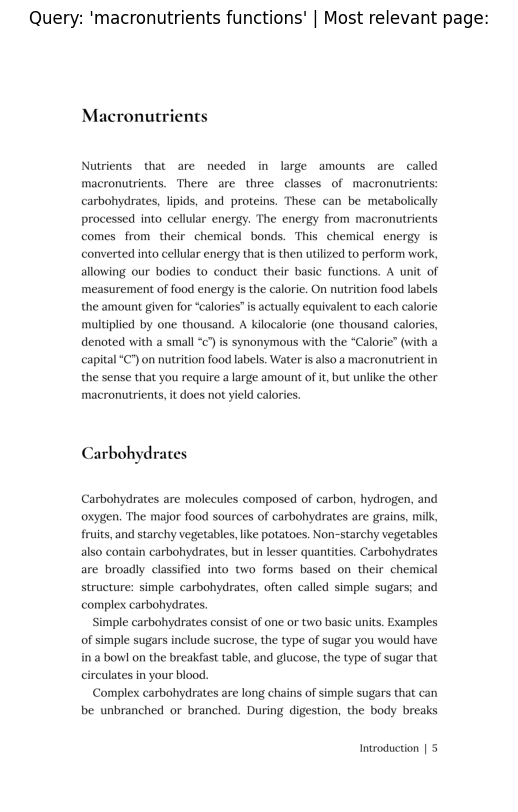

In [59]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

### Similarity measures: dot product and cosine similarity 

Let's talk similarity measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

Two of the most common you'll across are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) | 
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude. 

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

To make things bit more concrete, let's make simple dot product and cosine similarity functions and view their results on different vectors.

> **Note:** Similarity measures between vectors and embeddings can be used on any kind of embeddings, not just text embeddings. For example, you could measure image embedding similarity or audio embedding similarity. Or with text and image models like [CLIP](https://github.com/mlfoundations/open_clip), you can measure the similarity between text and image embeddings.

In [60]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


Notice for both dot product and cosine similarity the comparisons of `vector1` and `vector2` are the opposite of `vector1` and `vector4`.

Comparing `vector1` and `vector2` both equations return positive values (14 for dot product and 1.0 for cosine similarity). 

But comparing `vector1` and `vector4` the result is in the negative direction.

This makes sense because `vector4` is the negative version of `vector1`.

Whereas comparing `vector1` and `vector3` shows a different outcome.

For the dot product, the value is positive and larger then the comparison of two exactly the same vectors (32 vs 14).

However, for the cosine similarity, thanks to the normalization step, comparing `vector1` and `vector3` results in a postive value close to 1 but not exactly 1.

It is because of this that when comparing text embeddings, cosine similarity is generally favoured as it measures the difference in direction of a pair of vectors rather than difference in magnitude.

And it is this difference in direction that is more generally considered to capture the semantic meaning/vibe of the text.

The good news is that as mentioned before, the outputs of our embedding model `all-MiniLM-L6-v2` are already normalized.

So we can continue using the dot product (cosine similarity is dot product + normalization).

With similarity measures explained, let's functionize our semantic search steps from above so we can repeat them. 

### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [61]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Excellent! Now let's test our functions out.

In [62]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00005 seconds.


(tensor([0.5888, 0.4095, 0.3634, 0.3483, 0.3422], device='cuda:0'),
 tensor([ 822,   51,  275, 1623, 1616], device='cuda:0'))

In [63]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00005 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5888
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion. These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12 Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.4095
Vitamins Major Functions Water-soluble Thiamin (B1) Coenzyme, energy metabolism
assistance Riboflavin (B2 ) Coenzyme, energy metabolism assistance Niacin (B3)
Coenzyme, energy metabolism assistance Pantothenic acid (B5) Coenzyme, energy
metabolism assistance Pyridoxine (B6) Coenzyme, amino acid synthesis assistance
Biotin (B7) Coenzyme, amino acid and fatty acid metabolism Folate (B9) Coenzyme,
essential for growth Cobalamin (B12) Coenzyme, red blood cell synthesis C
(ascorbic acid) Collagen synthesis, antioxidant Fat-soluble A Visio

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [64]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 8 GB


Ok wonderful!

I'm running this notebook with a NVIDIA RTX 4090, so I've got 24GB of VRAM available.

However, this may be different on your end.

Looking at the table above, it seems we can run a ~7-10B parameter model in float16 precision pretty comfortably.

But we could also run a smaller one if we'd like.

Let's try out the recently released (at the time of writing, March 2024) LLM from Google, [Gemma](https://huggingface.co/blog/gemma).

Specifically, we'll use the `gemma-7b-it` version which stands for Gemma 7B Instruction-Tuned.

Instruction tuning is the process of tuning a raw language model to follow instructions.

These are the kind of models you'll find in most chat-based assistants such as ChatGPT, Gemini or Claude.

The following table shows different amounts of GPU memory requirements for different verions of the Gemma LLMs with varying levels of precision.

| Model             | Precision | Min-Memory (Bytes) | Min-Memory (MB) | Min-Memory (GB) | Recommended Memory (GB) | Hugging Face ID |
|-------------------|-----------|----------------|-------------|-------------| ----- | ----- |
| [Gemma 2B](https://huggingface.co/google/gemma-2b-it)          | 4-bit     | 2,106,749,952  | 2009.15     | 1.96        | ~5.0 | [`gemma-2b`](https://huggingface.co/google/gemma-2b) or [`gemma-2b-it`](https://huggingface.co/google/gemma-2b-it) for instruction tuned version | 
| Gemma 2B          | Float16   | 5,079,453,696  | 4844.14     | 4.73        | ~8.0 | Same as above |
| [Gemma 7B](https://huggingface.co/google/gemma-7b-it)          | 4-bit     | 5,515,859,968  | 5260.33     | 5.14        | ~8.0 | [`gemma-7b`](https://huggingface.co/google/gemma-7b) or [`gemma-7b-it`](https://huggingface.co/google/gemma-7b-it) for instruction tuned version |
| Gemma 7B          | Float16   | 17,142,470,656 | 16348.33    | 15.97       | ~19 | Same as above |

> **Note:** `gemma-7b-it` means "instruction tuned", as in, a base LLM (`gemma-7b`) has been fine-tuned to follow instructions, similar to [`Mistral-7B-v0.1`](https://huggingface.co/mistralai/Mistral-7B-v0.1) and [`Mistral-7B-Instruct-v0.1`](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1).
> 
> There are also further quantized and smaller variants of Gemma (and other LLMs) available in various formats such as GGUF. You can see many of these on [TheBloke account on Hugging Face](https://huggingface.co/TheBloke).
> 
> The version of LLM you choose to use will be largely based on project requirements and experimentation.

Based on the table above, let's write a simple if/else statement which recommends which Gemma variant we should look into using.

In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

### Loading an LLM locally

Alright! Looks like `gemma-7b-it` it is (for my local machine with an RTX 4090, change the `model_id` and `use_quantization_config` values to suit your needs)! 

There are plenty of examples of how to load the model on the `gemma-7b-it` [Hugging Face model card](https://huggingface.co/google/gemma-7b-it).

Good news is, the Hugging Face [`transformers`](https://huggingface.co/docs/transformers/) library has all the tools we need.

To load our LLM, we're going to need a few things:
1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) class (requires installing the [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example `gemma-7b-it`.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the [`transformers.AutoTokenzier.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer) method and passing it our model ID.
4. An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained) method and passing it our model ID as well as other various parameters.

As a bonus, we'll check if [Flash Attention 2](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2) is available using `transformers.utils.is_flash_attn_2_available()`. Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it by following the instructions on the [GitHub repo](https://github.com/Dao-AILab/flash-attention). 

> **Note:** Flash Attention 2 currently works on NVIDIA GPUs with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper architectures). We can check our GPU compute capability score with [`torch.cuda.get_device_capability(0)`](https://pytorch.org/docs/stable/generated/torch.cuda.get_device_capability.html). 

> **Note:** To get access to the Gemma models, you will have to [agree to the terms & conditions](https://huggingface.co/google/gemma-7b-it) on the Gemma model page on Hugging Face. You will then have to authorize your local machine via the [Hugging Face CLI/Hugging Face Hub `login()` function](https://huggingface.co/docs/huggingface_hub/en/quick-start#authentication). Once you've done this, you'll be able to download the models. If you're using Google Colab, you can add a [Hugging Face token](https://huggingface.co/docs/hub/en/security-tokens) to the "Secrets" tab.
>
> Downloading an LLM locally can take a fair bit of time depending on your internet connection. Gemma 7B is about a 16GB download and Gemma 2B is about a 6GB download.

Let's do it!

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)

from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
model_id = model_id # (we already set this above)

print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

In [72]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
     

In [73]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

In [74]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2106749952, 'model_mem_mb': 2009.15, 'model_mem_gb': 1.96}

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you should use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.

For example, the `gemma-7b-it` model has been trained in a dialogue fashion (instruction tuning).

`tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.



> **Note:** The following demo has been modified from the Hugging Face model card for [Gemma 7B](https://huggingface.co/google/gemma-7b-it). Many similar demos of usage are available on the model cards of similar models.

In [75]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Woohoo! We just generated some text on our local GPU!

Well not just yet...

Our LLM accepts tokens in and sends tokens back out.

We can conver the output tokens to text using [`tokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode).

In [76]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:** Our body uses carbohydrates for energy. They are the primary fuel for our cells and tissues.
* **Protein:** Protein is essential for building and repairing tissues, making enzymes, and producing hormones.
* **Fat:** Fat provides energy, helps absorb vitamins, and helps to insulate the body.

**Macronutrient Ratios:**

* **Carbohydrates:** Our bodies need around 45-65% of our total calories from carbohydrates.
* **Protein:** We need around 1.6-2.2 grams of protein per kilogram of body weight per day.
* **Fat:** We need around 20-30% of our total calories from fat.

**How Macronutrients Work Together:**

Macronutrients work together to provide the body with the energy and building blocks it needs to func

Woah! That looks like a pretty good answer.

But notice how the output contains the prompt text as well?

How about we do a little formatting to replace the prompt in the output text?

> **Note:** `"<bos>"` and `"<eos>"` are special tokens to denote "beginning of sentence" and "end of sentence" respectively.

In [77]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:** Our body uses carbohydrates for energy. They are the primary fuel for our cells and tissues.
* **Protein:** Protein is essential for building and repairing tissues, making enzymes, and producing hormones.
* **Fat:** Fat provides energy, helps absorb vitamins, and helps to insulate the body.

**Macronutrient Ratios:**

* **Carbohydrates:** Our bodies need around 45-65% of our total calories from carbohydrates.
* **Protein:** We need around 1.6-2.2 grams of protein per kilogram of body weight per day.
* **Fat:** We need around 20-30% of our total calories from fat.

**How Macronutrients Work Together:**

Macronutrients work together to provide the body with the energy and building blocks it needs to function properly. For example:

* Carbohydrates are broken down i

In [78]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [79]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to get scores on 1680 embeddings: 0.00005 seconds.


(tensor([0.6783, 0.6435, 0.6234, 0.6099, 0.6008], device='cuda:0'),
 tensor([41, 47, 52, 42, 46], device='cuda:0'))

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

We'll apply the dialogue and chat template to our prompt before returning it as well.

> **Note:** The process of augmenting or changing a prompt to an LLM is known as prompt engineering. And the best way to do it is an active area of research. For a comprehensive guide on different prompt engineering techniques, I'd recommend the Prompt Engineering Guide ([promptingguide.ai](https://www.promptingguide.ai/)), [Brex's Prompt Engineering Guide](https://github.com/brexhq/prompt-engineering) and the paper [Prompt Design and Engineering: Introduction and Advanced Models](https://arxiv.org/abs/2401.14423).

In [80]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

Looking good! Let's try our function out.

In [81]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What are symptoms of pellagra?
[INFO] Time taken to get scores on 1680 embeddings: 0.00005 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone me

What a good looking prompt!

We can tokenize this and pass it straight to our LLM. 

In [82]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What are symptoms of pellagra?
RAG answer:
<bos>The relevant passage from the context is:

**Symptoms, including nausea, muscle cramps, confusion, dizziness, and in severe cases, coma and death result. Hyponatremia in endurance athletes (such as marathon runners) Sodium | 177**

This passage describes the severe health problems and even death that can result from a deficiency of niacin.<eos>
CPU times: total: 3.39 s
Wall time: 3.37 s


In [83]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [84]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What is the RDI for protein per day?
[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.
Answer:

The RDI for protein per day is not explicitly stated in the context, so I cannot
answer this question from the provided context.
Context items:


[{'page_number': 410,
  'sentence_chunk': 'Most nitrogen is lost as urea in the urine, but urea is also excreted in the feces. Proteins are also lost in sweat and as hair and nails grow. The RDA, therefore, is the amount of protein a person should consume in their diet to balance the amount of protein used up and lost from the body. For healthy adults, this amount of protein was determined to be 0.8 grams of protein per kilogram of body weight. You can calculate 410 | Proteins, Diet, and Personal Choices',
  'chunk_char_count': 466,
  'chunk_word_count': 87,
  'chunk_token_count': 116.5,
  'embedding': array([-9.37561225e-03,  2.44336352e-02,  1.52375340e-03,  1.21516092e-02,
         -2.10782774e-02, -8.45116470e-03,  9.26240757e-02,  6.39424026e-02,
         -8.43891501e-03,  3.38093005e-03, -6.27483353e-02,  3.63495126e-02,
         -6.98504820e-02,  4.13399786e-02, -7.17675388e-02, -4.12203670e-02,
          1.87483691e-02,  9.29907837e-04, -5.98888434e-02, -2.07411218e-03,
       

## Extensions

* May want to improve text extraction with something like Marker - https://github.com/VikParuchuri/marker
* Guide to more advanced PDF extraction - https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517 
* See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide 
* What happens when a query comes through that there isn't any context in the textbook on?
* Try another embedding model (e.g. Mixed Bread AI large, `mixedbread-ai/mxbai-embed-large-v1`, see: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)
* Try another LLM... (e.g. Mistral-Instruct)
* Try different prompts (e.g. see prompting techniques online)
* Our example only focuses on text from a PDF, however, we could extend it to include figures and images 
* Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)
* Vector database/index for larger setup (e.g. 100,000+ chunks)
* Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
* Optimizations for speed
    * See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one 
    * Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia 
    * See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM 
    * See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast 
    * Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention
* Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)
* Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see local example: https://www.gradio.app/guides/creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face 